In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import time

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype(np.float64) / 255.0
y = mnist.target.astype(int)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
n_components = 50
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

In [7]:
classes = np.unique(y_train)
K = len(classes)
N, D = X_train_pca.shape

priors = np.zeros(K)
means = np.zeros((K, D))
covs = np.zeros((K, D, D))

for k in classes:
    Xk = X_train_pca[y_train == k]
    priors[k] = Xk.shape[0] / N
    means[k] = Xk.mean(axis=0)
    # regularize covariance for numerical stability
    covs[k] = np.cov(Xk, rowvar=False) + 1e-6 * np.eye(D)

In [8]:
inv_covs = np.zeros_like(covs)
logdets = np.zeros(K)
for k in classes:
    inv_covs[k] = np.linalg.inv(covs[k])
    sign, ld = np.linalg.slogdet(covs[k])
    logdets[k] = ld

In [9]:
def log_multivariate_normal(x, mean, inv_cov, logdet):
    diff = x - mean
    return -0.5 * (np.einsum('...i,ij,...j->...', diff, inv_cov, diff) + logdet + D * np.log(2*np.pi))

In [10]:
t0 = time.time()
log_probs = np.zeros((X_test_pca.shape[0], K))
for k in classes:
    log_lik = log_multivariate_normal(X_test_pca, means[k], inv_covs[k], logdets[k])
    log_probs[:, k] = np.log(priors[k]) + log_lik
y_pred = np.argmax(log_probs, axis=1)
t1 = time.time()

In [11]:
print(f"Prediction time: {t1-t0:.2f}s for {X_test_pca.shape[0]} samples")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (Gaussian generative, {n_components} PCA comps): {acc:.4f}")
print(classification_report(y_test, y_pred, digits=4))

Prediction time: 1.16s for 14000 samples
Accuracy (Gaussian generative, 50 PCA comps): 0.9601
              precision    recall  f1-score   support

           0     0.9757    0.9877    0.9816      1381
           1     0.9941    0.9556    0.9744      1575
           2     0.9396    0.9685    0.9539      1398
           3     0.9531    0.9545    0.9538      1428
           4     0.9742    0.9685    0.9713      1365
           5     0.9620    0.9628    0.9624      1263
           6     0.9888    0.9658    0.9772      1375
           7     0.9732    0.9459    0.9593      1459
           8     0.8869    0.9590    0.9215      1365
           9     0.9573    0.9353    0.9462      1391

    accuracy                         0.9601     14000
   macro avg     0.9605    0.9603    0.9602     14000
weighted avg     0.9610    0.9601    0.9603     14000



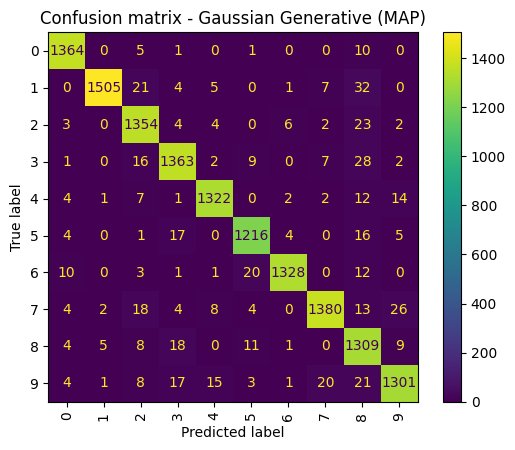

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion matrix - Gaussian Generative (MAP)")
plt.show()